## Session 1.2 Regression (Multivariate, Boston)

In [1]:
%pylab inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import IPython
import platform

from sklearn import preprocessing

print ('Python version:', platform.python_version())
print ('IPython version:', IPython.__version__)
print ('numpy version:', np.__version__)
print ('scikit-learn version:', sklearn.__version__)
print ('matplotlib version:', matplotlib.__version__)

Populating the interactive namespace from numpy and matplotlib
Python version: 3.6.8
IPython version: 6.2.1
numpy version: 1.13.3
scikit-learn version: 0.19.1
matplotlib version: 2.1.0


## Multivariate linear regression

To demonstrate multivariate regression in scikit-learn, we will apply it to a (very) simple and well-know problem: trying to predict the price of a house given some of its characteristics. As the dataset, we will use the 1978 Boston house price dataset (find the dataset description and attributes [here](http://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)).

In [16]:
from sklearn.datasets import load_boston
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
boston = load_boston()

print(type(boston))

print ('Boston dataset shape:{}'.format(boston.data.shape))
print ('Boston target shape:{}'.format(boston.target.shape))
print (boston.feature_names)

manual_split = False
if manual_split:
    numpy.random.seed(666)
    test_split = 0.2
    test_n = int(test_split*len(boston.data))
    test_indices = numpy.random.randint(0,len(boston.data), size=test_n)
    train_indices = sorted(set(range(len(boston.data))) - set(test_indices))

    X_train_boston_raw =boston.data[train_indices]
    X_test_boston_raw  =boston.data[test_indices]
    y_train_boston_raw =boston.target[train_indices]
    y_test_boston_raw  =boston.target[test_indices]
else:
    X_train_boston_raw, X_test_boston_raw, y_train_boston_raw, y_test_boston_raw = train_test_split(boston.data, boston.target, test_size=0.2, random_state=666)


numpy.set_printoptions(precision=4)
print("features:\n", X_train_boston_raw[0:3,:])

<class 'sklearn.utils.Bunch'>
Boston dataset shape:(506, 13)
Boston target shape:(506,)
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
features:
 [[  3.8710e-02   5.2500e+01   5.3200e+00   0.0000e+00   4.0500e-01
    6.2090e+00   3.1300e+01   7.3172e+00   6.0000e+00   2.9300e+02
    1.6600e+01   3.9690e+02   7.1400e+00]
 [  3.7750e+00   0.0000e+00   1.8100e+01   0.0000e+00   6.5500e-01
    5.9520e+00   8.4700e+01   2.8715e+00   2.4000e+01   6.6600e+02
    2.0200e+01   2.2010e+01   1.7150e+01]
 [  7.8420e-01   0.0000e+00   8.1400e+00   0.0000e+00   5.3800e-01
    5.9900e+00   8.1700e+01   4.2579e+00   4.0000e+00   3.0700e+02
    2.1000e+01   3.8675e+02   1.4670e+01]]


It is important for multivariate data to scale the dataset, in particular when features are measured in wildly differnt units, since otherwise those with large values will tend to eclipse the smaller ones and skew the result. To make sure data is all with the same ranges, we use a scaler.

Sklearn's StandardScaler transforms all ranges to have a mean of 0 and a std. dev of 1.  Once a scaler has been fit, it can be reused to apply the same scaling again.

Don't forget to scale the test X data as well as the training X data!

In [51]:
from sklearn.preprocessing import StandardScaler#, MinMaxScaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

#Create our scaled train and test datasets
X_train_boston = x_scaler.fit_transform(X_train_boston_raw) # preprocessing.scale(X_train_boston_raw) # shortcut to preprocessing.StandardScaler()
X_test_boston  = x_scaler.transform(X_test_boston_raw)
# y_train_boston = y_scaler.fit_transform(y_train_boston_raw.reshape(-1,1)).ravel()
# y_test_boston = y_scaler.transform(y_test_boston_raw.reshape(-1,1)).ravel()

y_train_boston = y_train_boston_raw
y_test_boston = y_test_boston_raw

print("Scaled features:\n", X_train_boston[0:3,:])
print("prices:\n", y_train_boston[0:3])

Scaled features:
 [[-0.4103  1.7706 -0.8507 -0.2982 -1.296  -0.1113 -1.3187  1.7002 -0.4108
  -0.6843 -0.8635  0.4442 -0.7775]
 [ 0.0284 -0.4759  1.0371 -0.2982  0.8714 -0.4715  0.5782 -0.435   1.655
   1.5379  0.805  -3.4921  0.61  ]
 [-0.3227 -0.4759 -0.4341 -0.2982 -0.1429 -0.4182  0.4716  0.2309 -0.6403
  -0.6009  1.1757  0.3376  0.2662]]
prices:
 [ 23.2  19.   17.5]


## Training using n-fold cross-validation

Previously we've trained using a dataset split into train and test subsets.  Another way to split your data is to use cross validation.

One of the main advantages of cross-validation is reducing the variance of the evaluation measures.  When you split the data manually, you will find that for each different split, your algorithm's performance will vary.  How do you know what is the right score?

Evaluation within machine learning generally assumes that the distribution of classes on your training and testing sets are similar. If not, you may get results that are not a truthful measure of the classifier's performance. Cross-validation lets us mitigate this: we are averaging on k different models built on k different datasets, so we are reducing variance and probably producing more realistic performance scores for our models.

Another benefit of cross-validation is that it allows us to make good use of the data we have available - each example acts as both a training datapoint and as a validation datapoint.

In [52]:
def train_and_evaluate(_clf, X_train, y_train, n_folds):
    _clf.fit(X_train, y_train)
    print ('Score on training set: {:.2f}'.format(_clf.score(X_train, y_train)))
    #create a k-fold cross validation iterator of k=5 folds
    data =X_train.shape[0]
    cv = sklearn.model_selection.KFold(n_splits= n_folds, shuffle=True, random_state=42)
    scores = sklearn.model_selection.cross_val_score(_clf, X_train, y_train, cv=cv)
    print ('Average score using {}-fold crossvalidation:{:.2f}'.format(n_folds,np.mean(scores)))
    return _clf

For classification, we used accuracy, the proportion of correctly classified test-instances, to summarise our method’s performance.

For regression, accuracy is a bad idea: we are predicting real values, so it's almost impossible to exactly predict the true value.

Instead, the default score function in scikit-learn is the coefficient of determination (or $R^2$ score), which measures the proportion of outcome variation explained by the model. $R^2 \in [0,1]$, and reaches 1 when the model perfectly predicts all the target values.

In [53]:
from sklearn import linear_model

#Use a Stochastic Gradient Descent Regressor - this is a general purpose linear regressor good for large datasets
clf_sgd = linear_model.SGDRegressor(loss='squared_loss', penalty=None, random_state=42, max_iter=10e5, tol=1e-4)
train_and_evaluate(clf_sgd, X_train_boston, y_train_boston, 5)

#print the hyperplane coefficients and their sum-of-squares

print(clf_sgd.coef_)
print(np.sum(np.square(clf_sgd.coef_)))

Score on training set: 0.76
Average score using 5-fold crossvalidation:0.73
[-0.4773  0.8623 -0.1151  0.8087 -1.234   3.2754 -0.091  -2.5864  0.9165
 -0.7839 -1.8943  1.1758 -3.6307]
40.194801078


In [54]:
print("TEST SET")
print("score=",clf_sgd.score(X_test_boston, y_test_boston))
y_hats = clf_sgd.predict(X_test_boston)
for y,yh in zip(y_test_boston_raw, y_hats):
    print(y,yh)

TEST SET
score= 0.624297521956
23.9 26.8642297927
17.8 23.5256396249
22.1 26.8154062508
37.3 33.8199472388
25.0 22.9988798753
19.7 20.8465921305
16.2 15.9551612055
18.9 23.2503163045
29.6 25.8209328621
18.4 18.8664698117
8.4 4.57638113078
24.7 25.523228866
19.8 22.8337147246
15.4 18.6314213524
22.2 23.6148229149
23.3 27.6108283702
26.6 27.7929886151
15.6 13.8508862593
12.6 18.5326616839
28.4 28.7159719126
37.0 31.5878335026
8.3 13.1058391121
7.2 7.9294210086
46.7 35.7983107236
26.5 26.5001472258
19.4 16.7481994216
24.5 21.1355341249
15.6 13.9433336216
37.9 33.6093232669
33.0 24.3698650674
43.5 39.6077752577
7.0 10.453957054
24.8 25.1584910267
22.5 17.450972248
19.4 23.7002936206
20.3 19.0313969643
31.0 34.9822829706
30.1 35.0028113969
21.0 21.6757815645
13.5 13.8532488956
24.4 23.6453116495
11.9 22.7579948318
24.5 27.7177284472
20.8 17.3096652252
23.7 28.0390939625
10.8 11.3986244489
23.7 26.3811459583
33.1 32.5818971134
22.9 28.0653278644
19.1 24.2150894836
22.3 26.4853527764
32.0 33.

Create a correlation matrix to help us pick out the most relevant factors.  We want those with the biggest (negative or positive) correlation with median value, MEDV.

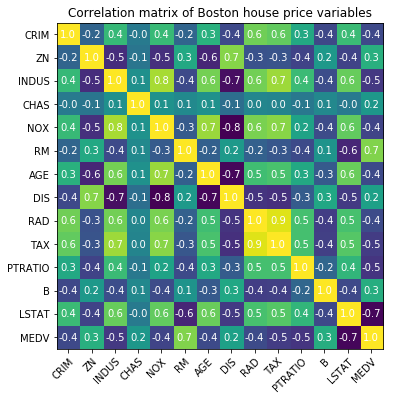

In [11]:
correlation_matrix = numpy.corrcoef(X_train_boston.T, y_train_boston)
fig, ax = plt.subplots()
im = ax.imshow(correlation_matrix)

# # We want to show all ticks...
ax.set_xticks(np.arange(len(boston.data.T)+1))
ax.set_yticks(np.arange(len(boston.data.T)+1))
# # ... and label them with the respective list entries
ax.set_xticklabels(list(boston.feature_names)+["MEDV"])
ax.set_yticklabels(list(boston.feature_names)+["MEDV"])



# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(boston.feature_names)+1):
    for j in range(len(boston.feature_names)+1):
        text = ax.text(j, i, round(correlation_matrix[i, j],1),
                       ha="center", va="center", color="w")

ax.set_title("Correlation matrix of Boston house price variables")
# fig.tight_layout()
fig.set_size_inches(6,6)
plt.show()


It looks like LSTAT and RM are most relevant.  Sklearn lets us automatically extra the K best features for explaining variance in the dataset...

[ 2  5  9 10 12]


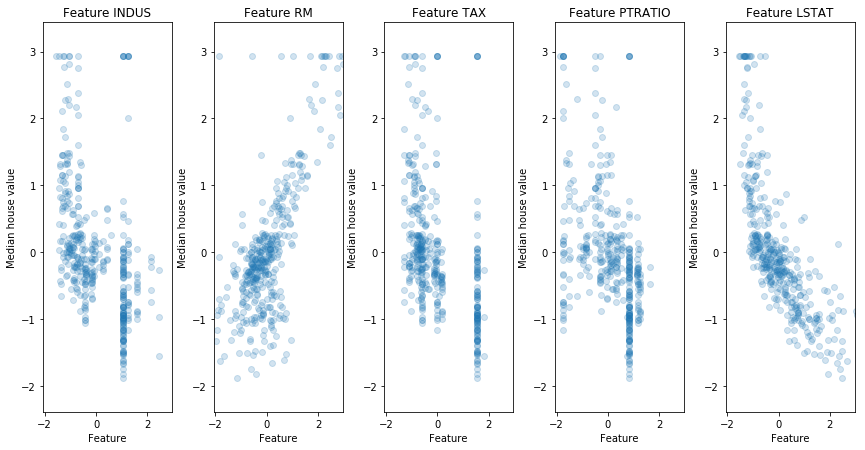

In [38]:
from sklearn.feature_selection import *
k=5

fs=SelectKBest(score_func=f_regression,k=k)
X_new=fs.fit_transform(X_train_boston,y_train_boston)
print (zip(fs.get_support(),boston.feature_names))

x_min, x_max = X_new[:,0].min() - .5, X_new[:, 0].max() + .5
y_min, y_max = y_train_boston.min() - .5, y_train_boston.max() + .5
#fig=plt.figure()

# Two subplots, unpack the axes array immediately
fig, axes = plt.subplots(1,k)
# plt.tight_layout()
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.1)
fig.set_size_inches(12,6)
fig.tight_layout()

cols = fs.get_support(indices=True)
print(cols)

if k>0:
    for i in range(k):
        axes[i].set_aspect('auto')
    #     axes[i].set_aspect('equal')
        axes[i].set_title('Feature ' + boston.feature_names[cols[i]])
        axes[i].set_xlabel('Feature')
        axes[i].set_ylabel('Median house value')
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_ylim(y_min, y_max)
        sca(axes[i])
        plt.scatter(X_new[:,i],y_train_boston, alpha=0.2)
    
X_test_new = X_test_boston[:,cols]

The default score function in scikit-learn is the _coefficient of determination_ (or $R^2$ score), which measures the proportion of outcome variation explained by the model. $R^2 \in [0,1]$, and reaches 1 when the model perfectly predicts all the target values.

In [55]:
from sklearn import linear_model

#Use a Stochastic Gradient Descent Regressor - this is a general purpose linear regressor good for large datasets
train_and_evaluate(clf_sgd, X_new, y_train_boston, 5)

#print the hyperplane coefficients and their sum-of-squares
print(clf_sgd.coef_)
print(np.sum(np.square(clf_sgd.coef_)))

print("\nTEST SET")
print(X_test_new.shape)
clf_sgd.fit(X_new, y_train_boston)
print("score=",clf_sgd.score(X_test_new, y_test_boston))
y_hats = clf_sgd.predict(X_test_new)
for y,yh in zip(y_test_boston, y_hats):
    print(y,yh)

Score on training set: 0.70
Average score using 5-fold crossvalidation:0.68
[ 0.4748  3.5776 -0.7679 -2.0135 -3.8184]
32.2486057054

TEST SET
(102, 5)
score= 0.585536654846
23.9 26.8041376512
17.8 23.6942011573
22.1 25.7766328312
37.3 31.3780188121
25.0 23.4420394379
19.7 22.4991600858
16.2 15.3123933834
18.9 21.9621956497
29.6 30.204515277
18.4 17.8870759574
8.4 7.23816326243
24.7 27.5392355272
19.8 24.597142938
15.4 18.0247007839
22.2 25.5981799687
23.3 30.654658367
26.6 27.8206441964
15.6 15.5697829844
12.6 18.1269143477
28.4 27.9537507809
37.0 32.5020184038
8.3 11.8418070392
7.2 5.63781699584
46.7 35.3688045239
26.5 25.3935875503
19.4 18.3419790243
24.5 19.6069905687
15.6 15.3582753446
37.9 32.1159066708
33.0 29.2231915812
43.5 38.8342102839
7.0 10.5084989363
24.8 27.5704597142
22.5 17.6687430436
19.4 25.4716233552
20.3 21.4837004342
31.0 33.8355243638
30.1 33.7059624304
21.0 22.1590337083
13.5 15.4827574432
24.4 24.1438001723
11.9 22.1677324081
24.5 29.2063388458
20.8 16.341889696

## Extra
Use a _non-linear_ regressor such as sklearn's SVR, and cross validate it on the Boston data.  Is it better?  If so, why might this be?  What about on the test dataset?

In [ ]:
from sklearn.svm import SVR
clf_sgd = SVR()
#...

## Summary
- We tried out multivariate regression on the Boston house price dataset, using k-fold cross validation to test our estimators
- We tried some feature selection using a correlation matrix and SelectKBest